# 0. Setup

In [1]:
# ! pip install urllib3==1.26.12
! pip install urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 5.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
! pip install transformers newspaper3k datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 211 kB 71.9 MB/s 
     |████████████████████████████████| 452 kB 70.9 MB/s 
     |████████████████████████████████| 7.6 MB 45.2 MB/s 
     |████████████████████████████████| 182 kB 63.3 MB/s 
     |████████████████████████████████| 7.4 MB 63.7 MB/s 
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 132 kB 69.8 MB/s 
     |████████████████████████████████| 212 kB 55.3 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=e826b39354724ec8f7e17716de993175c84287d244214f842424155bcefe75d4
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0

In [3]:
import urllib3
urllib3.__version__

'1.25.11'

In [4]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import datasets
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import spacy
# ! python -m spacy download en_core_web_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
import spacy

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# drive.flush_and_unmount()

In [9]:
! pwd

/content


In [10]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.1 Defining variables

In [11]:
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1
html_folder = HTML_FOLDER
# Cell 2
csv_path = 'url_classification_temporary536.csv'
usecols = ['File Name', 'Label']

usecols2 = ['url', 'true_label']

labels_encoded = {'Home Page': 0, 'Blog': 1, 'MISC': 2, 'Product Page': 3, 'Event': 4, 'Article': 5, 'Webinar': 6, 'PR': 7}
labels_decoded = {y: x for x, y in labels_encoded.items()}

nlp = spacy.load('en_core_web_sm')

In [12]:
csv_path2 = 'activities_labeled8.csv'

# 0.2 Functions

## Saving/loading variables

In [13]:
def save_variable(variable, variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [14]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [15]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  labels_reversed = {y: x for x, y in labels_encoded.items()}
  coef_importances = np.argsort(clf.coef_, axis=1)

  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_reversed[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, labels_encoded=labels_encoded, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  if labels_encoded:
    y_test = list(map(lambda x: labels_decoded[x], y_test))
    y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

In [16]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test_, y_test=y_valid_test_, y_pred=y_pred)

In [17]:
# IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# 0.3 (Optional) Load df_text1

In [18]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')
df_text1

Variable "df_text1" does not exist.
Variable "df_text1" exists.


,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load df_text2

In [ ]:
check_if_exists('df_text2')
df_text2 = read_variable('df_text2')
check_if_exists('df_text2')
df_text2

Variable "df_text2" does not exist.
Variable "df_text2" exists.


,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
499,http://capitalmarketsblog.accenture.com/role-s...,The role of stewardship in ESG and beyond. Env...,Blog
500,http://www.signanthealth.com/blog/econsent/eco...,eConsent Task Force Co-Chaired by Signant and ...,Blog
501,http://blog.eclinicalworks.com/a-better-front-...,A Better Front Office Could Be Just Minutes Aw...,Blog
502,http://financialservicesblog.accenture.com/don...,Don’t Ignore the SG in ESG: Why Companies shou...,Blog


# 0.5 (Optional) Load df_text

In [ ]:
check_if_exists('df_text')
df_text = read_variable('df_text')
check_if_exists('df_text')
df_text

Variable "df_text" does not exist.
Variable "df_text" exists.


,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
613,The role of stewardship in ESG and beyond. Env...,Blog,http://capitalmarketsblog.accenture.com/role-s...,The role stewardship ESG beyond Environmental ...,the role of stewardship in esg and beyond . en...,role stewardship esg beyond environmental soci...,the role of stewardship in esg and beyond . en...
614,eConsent Task Force Co-Chaired by Signant and ...,Blog,http://www.signanthealth.com/blog/econsent/eco...,eConsent Task Force CoChaired Signant Medidata...,eConsent Task Force Co - chair by Signant and ...,eConsent Task Force Co chair Signant Medidata ...,econsent task force co - chaired by signant an...
615,A Better Front Office Could Be Just Minutes Aw...,Blog,http://blog.eclinicalworks.com/a-better-front-...,A Better Front Office Could Be Just Minutes Aw...,a Better Front Office could be just Minutes aw...,Better Front Office could Minutes away healow ...,a better front office could be just minutes aw...
616,Don’t Ignore the SG in ESG: Why Companies shou...,Blog,http://financialservicesblog.accenture.com/don...,Dont Ignore SG ESG Why Companies Focus Social ...,do not ignore the sg in esg : why company shou...,ignore sg esg company focus Social Governance ...,do n’t ignore the sg in esg : why companies sh...


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
STOPWORDS = set(stopwords.words('english'))

In [ ]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [ ]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (535, 2)
Final shape: (461, 2)


In [ ]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        162
MISC              87
Blog              84
Product Page      44
Article           42
Event             15
White Paper       12
Education          6
?                  3
About Page         2
Press Release      2
Video Content      1
Publication        1
Name: label, dtype: int64

In [ ]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [ ]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [ ]:
# Important cell # 6
y = df[TARGET].tolist()

In [ ]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [ ]:
len(y), len(summaries)

(461, 461)

In [ ]:
# Important cell # 7.5
df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

In [ ]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [ ]:
save_variable(df_text1, 'df_text1')

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [19]:
! pwd

/content/drive/MyDrive/url_classification


In [20]:
csv_path2

'activities_labeled8.csv'

In [22]:
df2 = pd.read_csv(csv_path2,
                 usecols=usecols2,
                  )
df2.rename(columns={usecols2[1]: 'label'}, inplace=True)
df2 = df2[~df2['label'].isna()]
df2.reset_index(drop=True, inplace=True)
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
860,Blog,http://blog.eclinicalworks.com/a-better-front-...
861,MISC,http://www.accenture.com/us-en/blogs/business-...
862,Blog,http://financialservicesblog.accenture.com/don...
863,Blog,http://medrio.com/resource/patient-data-privac...


In [23]:
try:
  labels_already_read = read_variable('labels_already_read')
except FileNotFoundError:
  labels_already_read = list()
len(labels_already_read)

504

In [24]:
try:
  indexes_already_read = read_variable('indexes_already_read')
except FileNotFoundError:
  indexes_already_read = list()
len(indexes_already_read)

504

In [25]:
try:
  summaries2_already_read = read_variable('summaries2_already_read')
except FileNotFoundError:
  summaries2_already_read = list()
len(summaries2_already_read)

504

In [26]:
try:
  urls_already_read = read_variable('urls_already_read')
except FileNotFoundError:
  urls_already_read = list()
len(urls_already_read) # IT'S OK THAT THIS LENGTH IS DIFFERENT

676

In [27]:
urls = df2['url']

In [28]:
# Use the mask to select the elements in a that are not in b
mask = np.isin(urls, urls_already_read)
urls_to_read = urls[~mask]
len(urls_to_read) # There may be less than the difference of urls and urls_already_read, given that some urls_to_read may be repeated from before, and that's ok.

180

In [ ]:
# try:
#   urls_to_read = list(set(urls).difference(set(urls_already_read)))
# except TypeError:
#   urls_to_read = urls
# len(urls_to_read)

In [66]:
urls_to_read.index[:50]

Int64Index([148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161,
            162, 163, 164, 166, 168, 169, 170, 172, 173, 175, 176, 177, 178,
            179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192,
            193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203],
           dtype='int64')

In [ ]:
# summaries2_already_read[-1]

In [116]:
# Important cell # 5
summaries2_new = list()
indexes_new = list()

idx_label_to_remove = list()
idx_label = 0

for i, url in enumerate(urls_to_read, len(urls_already_read)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    summary = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    summaries2_new.append(summary)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    idx_label_to_remove.append(idx_label)
    print(f'{i}: ERROR: url "{url}" was not read successfully.')
  
  idx_label += 1

676: url "http://www.clinicalink.com/ci_events/core-west-coast/" read successfully.
677: url "http://www.digitalpharmaeast.com/" read successfully.
678: url "http://www.terrapinn.com/conference/world-drug-safety-us/agenda.stm" read successfully.
679: ERROR: url "http://www.scopesummit.com/" was not read successfully.
680: url "http://usaindiachamber.org/agenda.php" read successfully.
681: url "http://clario.com/insights/events/dct-decentralized-clinical-trials/" read successfully.
682: url "http://info.advarra.com/decentralized-clinical-trials-symposium-od.html" read successfully.
683: url "http://biofuture.com/about-the-event/" read successfully.
684: url "http://www.industries.veeva.com/summit2021" read successfully.
685: url "http://informaconnect.com/clinical-trials-europe/" read successfully.
686: url "http://www.magiworld.org/Home" read successfully.
687: url "http://www.ersnet.org/congress-and-events/congress/" read successfully.
688: url "http://www.eventbrite.co.uk/e/ddd-east-

In [ ]:
# Important cell # 5
summaries2_new = list()
indexes_new = list()

for i, url in enumerate(urls_to_read, len(urls_already_read)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    summary = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    summaries2_new.append(summary)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    print(f'{i}: ERROR: url "{url}" was not read successfully.')

0: url "http://www.nctech.org/events/event/2021/awards-gala.html" read successfully.
1: ERROR: url "http://www.himss.org/global-conference/digital-about-program" was not read successfully.
2: url "http://cdd-biologics.com/" read successfully.
3: ERROR: url "http://events.cbinsights.com/future-of-health/home" was not read successfully.
4: ERROR: url "http://sfesummit.com/" was not read successfully.
5: url "http://www.obviohealth.com/events/informa-1-2021" read successfully.
6: url "http://www.genesisconference.com/" read successfully.
7: url "http://www.iqvia.com/events/2021/11/biodata-world-congress-2021" read successfully.
8: url "http://www.gartner.com/en/conferences/na/data-analytics-us" read successfully.
9: url "http://www.sitcancer.org/education/annualmeeting" read successfully.
10: url "http://www.bio.org/events/bio-digital/announcements/start-planning-bio-digital-2021" read successfully.
11: url "http://www.ispor.org/" read successfully.
12: url "http://www.iscr.org/PastEvent_

In [117]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
860,Blog,http://blog.eclinicalworks.com/a-better-front-...
861,MISC,http://www.accenture.com/us-en/blogs/business-...
862,Blog,http://financialservicesblog.accenture.com/don...
863,Blog,http://medrio.com/resource/patient-data-privac...


In [118]:
urls_to_read

148    http://www.clinicalink.com/ci_events/core-west...
149                    http://www.digitalpharmaeast.com/
150    http://www.terrapinn.com/conference/world-drug...
151                          http://www.scopesummit.com/
152                http://usaindiachamber.org/agenda.php
                             ...                        
661    http://event.on24.com/wcc/r/3601629/4AB52B45C4...
662    http://www.iqvia.com/locations/united-states/e...
663    http://event.on24.com/wcc/r/3618445/78DB0A6490...
664    http://www.medable.com/medable-events/dct-mast...
665    http://www.iqvia.com/events/2021/03/evolution-...
Name: url, Length: 180, dtype: object

In [119]:
len(urls_to_read), len(indexes_new) # the difference is the number of errors when reading urls before

(180, 159)

In [120]:
# indexes_new

In [121]:
len(urls_already_read) # first index that will be applied to urls_to_read

676

In [122]:
# urls_relevant_to_read = urls_to_read.copy()
# urls_relevant_to_read.index = np.arange(len(urls_already_read), len(urls_already_read) + len(urls_to_read)) # addapt indexes
# urls_relevant_to_read[indexes_new] # removing those urls that threw errors before and create labels to read

In [123]:
# np.arange(len(urls_already_read), len(urls_already_read) + len(urls_to_read))

In [162]:
rel_idxs = urls_to_read.index
labels_to_read = df2.loc[rel_idxs, TARGET] #.tolist()
labels_to_read

148              MISC
149         Home Page
150                 -
151         Home Page
152    Virtual Summit
            ...      
661     Digital event
662           Webinar
663           Webinar
664         Home Page
665           Webinar
Name: label, Length: 180, dtype: object

In [163]:
assert (labels_to_read == df2.loc[labels_to_read.index, TARGET]).all()

In [164]:
df2.loc[labels_to_read.index, TARGET].tolist()[:5]

['MISC', 'Home Page', '-', 'Home Page', 'Virtual Summit']

In [165]:
# df2.loc[urls_relevant_to_read[indexes_new].index, TARGET].tolist()

In [166]:
labels_to_read.reset_index(drop=True, inplace=True)
labels_to_read

0                MISC
1           Home Page
2                   -
3           Home Page
4      Virtual Summit
            ...      
175     Digital event
176           Webinar
177           Webinar
178         Home Page
179           Webinar
Name: label, Length: 180, dtype: object

In [167]:
idx_label_to_remove

[3,
 13,
 14,
 15,
 18,
 19,
 34,
 35,
 38,
 49,
 53,
 61,
 63,
 67,
 69,
 89,
 96,
 104,
 140,
 145,
 151]

In [168]:
labels_to_read = labels_to_read.drop(idx_label_to_remove).tolist()
len(labels_to_read)

159

In [169]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
860,Blog,http://blog.eclinicalworks.com/a-better-front-...
861,MISC,http://www.accenture.com/us-en/blogs/business-...
862,Blog,http://financialservicesblog.accenture.com/don...
863,Blog,http://medrio.com/resource/patient-data-privac...


In [170]:
df2.loc[df2['url'] == 'http://xtalks.com/webinars/improving-pharmacovigilance-outsourcing-with-modern-technologies/', :]

,label,url
611,Webinar,http://xtalks.com/webinars/improving-pharmacov...


In [171]:
df2.loc[df2['url'] == 'http://procurementleaders.com/events/americas-procurement-congress/', :]

,label,url
275,Event,http://procurementleaders.com/events/americas-...


In [172]:
len(indexes_new)

159

In [173]:
len(labels_to_read)

159

In [175]:
labels_to_read

['MISC',
 'Home Page',
 '-',
 'Virtual Summit',
 'Event',
 '?',
 'Event',
 '?',
 'Event',
 'Event',
 'Event',
 'MISC',
 'Event',
 'Event',
 'Webinar',
 'Event',
 'Event',
 'MISC',
 'Home Page',
 'Webinar',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Event',
 'Digital event',
 'Home Page',
 'Home Page',
 'Event',
 'Event',
 'Digital event',
 'Event',
 'Event',
 'Event',
 '-',
 'Event',
 'Event',
 'Event',
 'Event',
 'Digital event',
 'Event',
 '-',
 'Event',
 '-',
 'Event',
 'Digital event',
 'Event',
 '-',
 'Event',
 'MISC',
 'Event',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Home Page',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Digital event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event

In [176]:
labels = labels_already_read + labels_to_read
len(labels), len(labels_already_read), len(labels_to_read)

(663, 504, 159)

In [195]:
save_variable(labels, 'labels_already_read')

In [177]:
indexes = indexes_already_read + indexes_new
len(indexes), len(indexes_already_read), len(indexes_new)

(663, 504, 159)

In [196]:
save_variable(indexes, 'indexes_already_read')

In [178]:
summaries2 = summaries2_already_read + summaries2_new
len(summaries2), len(summaries2_already_read), len(summaries2_new)

(663, 504, 159)

In [197]:
save_variable(summaries2, 'summaries2_already_read')

In [179]:
urls = urls_already_read + urls_to_read.tolist() # it is necessary to change type and order of urls, though they are the same, also eliminates urls repeated in urls_to_read and urls_already_read
len(urls), len(urls_already_read), len(urls_to_read)

(856, 676, 180)

In [198]:
save_variable(urls, 'urls_already_read')

In [180]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
860,Blog,http://blog.eclinicalworks.com/a-better-front-...
861,MISC,http://www.accenture.com/us-en/blogs/business-...
862,Blog,http://financialservicesblog.accenture.com/don...
863,Blog,http://medrio.com/resource/patient-data-privac...


In [181]:
len(summaries2), len(pd.Series(urls).loc[indexes]), len(indexes), len(labels)

(663, 663, 663, 663)

In [182]:
assert len(summaries2) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)
len(summaries2), len(pd.Series(urls).loc[indexes]), len(indexes), len(labels)

(663, 663, 663, 663)

In [183]:
df_text2 = pd.DataFrame(
    {'url': pd.Series(urls).loc[indexes],
     TEXT: summaries2,
     TARGET: labels,
     }
     ).reset_index(drop=True)

In [184]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
658,http://event.on24.com/wcc/r/3601629/4AB52B45C4...,Global Medicines Outlook to 2026.,Digital event
659,http://www.iqvia.com/locations/united-states/e...,"""Next Best"" Brings Intelligence to the Point o...",Webinar
660,http://event.on24.com/wcc/r/3618445/78DB0A6490...,Clinical Data Flow: The Foundation of a Biosta...,Webinar
661,http://www.medable.com/medable-events/dct-mast...,Medable: Virtual Clinical Trial Solutions (DCT...,Home Page


In [185]:
df_text2[TARGET].value_counts()

Webinar                  163
Event                    162
PR                       125
-                         59
MISC                      43
Article                   28
Home Page                 23
Podcast                   14
Digital event             14
Blog                      11
?                          9
Video Content              7
Webcast                    2
White Paper                1
Virtual Summit             1
Google Form for Event      1
Name: label, dtype: int64

In [186]:
df_text2.loc[501, 'text']

'A Better Front Office Could Be Just Minutes Away. How healow can help with post-pandemic workflows  You need only a few minutes to read this blog, but there are even faster ways to transform your front office. We’d love for you to keep reading, but you could just give us a call right now.  Why? Because in just a few minutes, our product experts can explain how integrated solutions from eClinicalWorks® and healow® can dramatically improve Patient Engagement while reducing burdens on your front office staff.  If your current EHR isn’t up to the challenges of COVID-19, eClinicalWorks can show you a comprehensive, fully integrated product to transform every aspect of your practice.  If you’re already an eClinicalWorks customer, consider registering for our upcoming 2021 healow and eClinicalWorks virtual National Conference, being held Oct. 7-8. It’s free for all customers.  Connecting with patients — faster and better  Here are just a few of the things we offer that could help you reinven

In [187]:
# df_text2 = df2.loc[indexes, :]
# df_text2[TEXT] = summaries2
# # df_text2['url'] = df_text2['url'].loc[indexes]
# df_text2['url'] = pd.Series(urls) #.loc[indexes] # Assigning the text to the correct url
# # df_text2[TARGET] = pd.Series(labels)

In [188]:
df_text2.loc[df_text2['url'] == 'http://xtalks.com/webinars/improving-pharmacovigilance-outsourcing-with-modern-technologies/', :]

,url,text,label
334,http://xtalks.com/webinars/improving-pharmacov...,Improving Pharmacovigilance Outsourcing with M...,Webinar


In [189]:
df_text2.loc[df_text2['url'] == 'http://www.terrapinn.com/conference/world-orphan-drug-congress/', :]

,url,text,label
61,http://www.terrapinn.com/conference/world-orph...,30 October 2023 - 2 November 2023. Europe's Mo...,Event


In [190]:
df2.loc[df2['url'] == 'http://www.terrapinn.com/conference/world-orphan-drug-congress/', :]

,label,url
71,Event,http://www.terrapinn.com/conference/world-orph...


In [192]:
df_text2.shape

(663, 3)

In [193]:
# df_text2 = df2.loc[indexes, :]
# df_text2[TEXT] = summaries2
# df_text2['url'] = pd.Series(urls).loc[indexes]
# df_text2 = df_text2[df_text2[TARGET] != '-'] # .reset_index(drop=True)
df_text2.tail(10)

,url,text,label
653,http://www.iqvia.com/locations/united-states/e...,Curating Data to Enable Patient Care Innovatio...,Webinar
654,http://www.iqvia.com/locations/united-states/e...,"The 2021 US Pharmaceutical Market: Trends, Iss...",Webinar
655,http://event.on24.com/wcc/r/3412736/CFBA0C6151...,PSP Design away from the norm: Adolescents and...,Digital event
656,http://www.iqvia.com/locations/united-states/e...,IQVIA Connected Intelligence™ for Integrated G...,Webinar
657,http://www.iqvia.com/locations/united-states/e...,Overcoming Barriers to Treatment Adherence Wit...,Webinar
658,http://event.on24.com/wcc/r/3601629/4AB52B45C4...,Global Medicines Outlook to 2026.,Digital event
659,http://www.iqvia.com/locations/united-states/e...,"""Next Best"" Brings Intelligence to the Point o...",Webinar
660,http://event.on24.com/wcc/r/3618445/78DB0A6490...,Clinical Data Flow: The Foundation of a Biosta...,Webinar
661,http://www.medable.com/medable-events/dct-mast...,Medable: Virtual Clinical Trial Solutions (DCT...,Home Page
662,http://www.iqvia.com/events/2021/03/evolution-...,Evolution of MedTech Go-To-Market Models in th...,Webinar


In [194]:
save_variable(df_text2, 'df_text2')

In [ ]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
499,http://capitalmarketsblog.accenture.com/role-s...,The role of stewardship in ESG and beyond. Env...,Blog
500,http://www.signanthealth.com/blog/econsent/eco...,eConsent Task Force Co-Chaired by Signant and ...,Blog
501,http://blog.eclinicalworks.com/a-better-front-...,A Better Front Office Could Be Just Minutes Aw...,Blog
502,http://financialservicesblog.accenture.com/don...,Don’t Ignore the SG in ESG: Why Companies shou...,Blog


In [200]:
df_text2[TARGET].value_counts()

Webinar                  163
Event                    162
PR                       125
-                         59
MISC                      43
Article                   28
Home Page                 23
Podcast                   14
Digital event             14
Blog                      11
?                          9
Video Content              7
Webcast                    2
White Paper                1
Virtual Summit             1
Google Form for Event      1
Name: label, dtype: int64

# 0.8 (Optional) Create and save "df_text" (joining df_text1 and df_text2 and cleaning)

In [201]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [202]:
df_text1['url'] = 'Not provided'

In [203]:
df_text2['url'].value_counts().values

array([27,  6,  5,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [204]:
# We see that there are duplicated urls, so we will delete them.
print(f"df_text2 original shape: {df_text2.shape}")
df_text2 = df_text2[~df_text2['url'].duplicated()]
print(f"df_text2 final shape: {df_text2.shape}")

df_text2 original shape: (663, 3)
df_text2 final shape: (620, 3)


In [205]:
# We don't have duplicate values anymore
df_text2['url'].value_counts().values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [206]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)
df_text 

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,When Is ADA Compliance Legally Required?. The ...,White Paper,Not provided
2,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
3,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
4,FAQs for some new features available in the Be...,Blog,Not provided
...,...,...,...
1076,Global Medicines Outlook to 2026.,Digital event,http://event.on24.com/wcc/r/3601629/4AB52B45C4...
1077,"""Next Best"" Brings Intelligence to the Point o...",Webinar,http://www.iqvia.com/locations/united-states/e...
1078,Clinical Data Flow: The Foundation of a Biosta...,Webinar,http://event.on24.com/wcc/r/3618445/78DB0A6490...
1079,Medable: Virtual Clinical Trial Solutions (DCT...,Home Page,http://www.medable.com/medable-events/dct-mast...


In [207]:
df_text[TARGET].value_counts()

Home Page                182
Event                    172
Webinar                  158
PR                       125
MISC                     104
Blog                      95
Article                   70
-                         55
Product Page              44
Digital event             14
Podcast                   14
White Paper               13
?                         12
Video Content              8
Education                  6
Press Release              2
About Page                 2
Webcast                    2
Publication                1
Virtual Summit             1
Google Form for Event      1
Name: label, dtype: int64

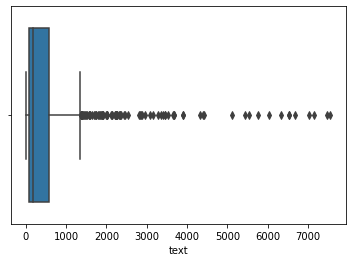

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

In [ ]:
THRESHOLD1 = 38
THRESHOLD2 = 50

characters = df_text['text'].str.split().str.len()
df_text.loc[(characters > THRESHOLD1) & (characters < THRESHOLD2), 'text'].tolist()

['Expert Digital Marketing Services. “Expert Digital Marketing Services made it possible for our business to focus on what we do best. Their knowledge and expertise has freed up valuable time. One of the best agencies I’ve worked with and I highly recommend them”',
 'GuestPostWala. Are you a cyclist? If you are, then you know how much of a hassle it is to store your bike at home or in the garage. Also, it is not convenient if your bike gets stolen or broken down….',
 'Maryland, Virginia, Web & Graphic Design, Digital Marketing Agency. Serving the biomedical industry as innovators and educators, ABI spearheads the creation and manufacture of products instrumental to improving human diagnostics.  HindSite Interactive provides design, development and maintenance including: site design and development; e-commerce; administration',
 'AI Chatbot Software for Automated Customer Service. Any channel, anytime  Rather than relying on single-point solutions for each support channel, pair live cha

In [208]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.2) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

58.0

In [209]:
values.describe()[['25%', '75%']]

25%     73.0
75%    534.0
Name: text, dtype: float64

In [210]:
# Cell 8

minimum_words = 61

maximum_classes = 7

# Important cell # 8

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  df_text = df_text[df_text[TARGET].isin(relevant_labels)] # this is to erase all classes after 'maximum_classes'
  # df_text.loc[~df_text[TARGET].isin(relevant_labels), TARGET] = 'MISC' # this is to not erase them, but change their value to 'MISC'

df_text.reset_index(drop=True, inplace=True)

In [211]:
df_text[TARGET].value_counts()

Webinar      134
Event        132
PR           124
Home Page    100
Blog          94
MISC          72
Article       66
Name: label, dtype: int64

In [212]:
df_text

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
3,FAQs for some new features available in the Be...,Blog,Not provided
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided
...,...,...,...
717,IQVIA Connected Intelligence™ for Integrated G...,Webinar,http://www.iqvia.com/locations/united-states/e...
718,Overcoming Barriers to Treatment Adherence Wit...,Webinar,http://www.iqvia.com/locations/united-states/e...
719,"""Next Best"" Brings Intelligence to the Point o...",Webinar,http://www.iqvia.com/locations/united-states/e...
720,Medable: Virtual Clinical Trial Solutions (DCT...,Home Page,http://www.medable.com/medable-events/dct-mast...


We see that there are repeated urls, so we will delete duplicates.

In [213]:
# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 474642
Amount of unique words before cleaning text: 44845

Amount of words after cleaning text: 293865
Amount of unique words before cleaning text: 27226


In [214]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 474642
Amount of unique words before lemmatizing text: 44845

Amount of words after lemmatizing text: 571088
Amount of unique words before lemmatizing text: 21223


In [215]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 571088
Amount of unique words before cleaning lemmatized text: 21223

Amount of words after cleaning lemmatized text: 280169
Amount of unique words before cleaning lemmatized text: 20039


In [216]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [217]:
df_text.loc[0, TEXT]

"2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together."

In [218]:
# df_text.loc[0, 'lemmatized_text']

In [219]:
# df_text.loc[0, 'lemmatized_cleaned_text']

In [220]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [221]:
# print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# tokenized = [word_tokenize(string) for string in df_text[TEXT]]
# df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
# print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

In [222]:
save_variable(df_text, 'df_text')

In [223]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
717,IQVIA Connected Intelligence™ for Integrated G...,Webinar,http://www.iqvia.com/locations/united-states/e...,IQVIA Connected Intelligence Integrated Global...,IQVIA Connected Intelligence ™ for Integrated ...,IQVIA Connected Intelligence Integrated Global...,iqvia connected intelligence ™ for integrated ...
718,Overcoming Barriers to Treatment Adherence Wit...,Webinar,http://www.iqvia.com/locations/united-states/e...,Overcoming Barriers Treatment Adherence With F...,overcome Barriers to Treatment Adherence with ...,overcome Barriers Treatment Adherence Flexible...,overcoming barriers to treatment adherence wit...
719,"""Next Best"" Brings Intelligence to the Point o...",Webinar,http://www.iqvia.com/locations/united-states/e...,Next Best Brings Intelligence Point Execution ...,""" Next good "" bring Intelligence to the Point ...",Next good bring Intelligence Point Execution l...,""" next best "" brings intelligence to the point..."
720,Medable: Virtual Clinical Trial Solutions (DCT...,Home Page,http://www.medable.com/medable-events/dct-mast...,Medable Virtual Clinical Trial Solutions DCT P...,medable : Virtual Clinical Trial Solutions ( D...,medable Virtual Clinical Trial Solutions DCT P...,medable : virtual clinical trial solutions ( d...


# 0.9 Further EDA and preprocessing on "df_text"

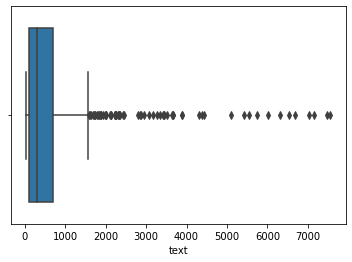

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

values.describe()[['25%', '75%']]

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page,Teach Yourself Visually Search Engine Optimiza...,teach yourself Visually Search Engine Optimiza...,teach Visually Search Engine Optimization whet...,teach yourself visually search engine optimiza...
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page,The Art SEO 2nd Edition Four acknowledged expe...,"the art of seo , 2nd Edition . four acknowledg...",art seo 2nd Edition four acknowledge expert se...,"the art of seo , 2nd edition . four acknowledg..."
328,Submit A Guest Post – Guidelines (Write for Us...,MISC,Submit A Guest Post Guidelines Write Us We acc...,submit a Guest Post – Guidelines ( write for U...,submit Guest Post Guidelines write Us accept G...,submit a guest post – guidelines ( write for u...
329,Fully Managed Magento Hosting — JetRails. Full...,MISC,Fully Managed Magento Hosting JetRails Fully M...,fully manage Magento Hosting — JetRails . full...,fully manage Magento Hosting JetRails fully ma...,fully managed magento hosting — jetrails . ful...


In [ ]:
df_text['w2v_text'].tolist()

['write for us . want to write for us ?   digital lamp , is one of the fastest - growing tech blog . we allow you an endless opportunity for new authors , technical content writers , freelance content writing professionals , and guest writers to technology + “ write for us ” + guest post ( contribute or submit guest post article ) about the topics related to technology , business , internet , gadgets , digital marketing , security , seo , tech blog , etc .   technology is the way progressive for online businesses . why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend .   you will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationships with bloggers and readers and rank better in the search engines .   all you need to do is meet the criteria set out by the technology blogs be

In [ ]:
df_text[TARGET].value_counts()

0    128
7    124
1    110
6     85
2     79
5     66
4     55
3     44
Name: label, dtype: int64

In [ ]:
# df_text[TARGET].replace({1: 5}, inplace=True) # make Blog and Article a single category

In [ ]:
df_text[TARGET].value_counts()

5    176
0    128
7    124
6     85
2     79
4     55
3     44
Name: label, dtype: int64

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

# 1. Bag of Words approach

## Preprocessing

In [224]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [225]:
# # Working only with df_text2
# df_text = df_text[(df_text['url'] != 'Not provided') & (df_text[TARGET].isin([7, 6, 4, 1, 5]))]

In [226]:
df_text[TARGET].value_counts()

6    134
4    132
7    124
0    100
1     94
2     72
5     66
Name: label, dtype: int64

In [227]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [228]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((577, 1), (145, 1), (577,), (145,))

In [229]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.1862


In [230]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 1820),
 ('content', 1419),
 ('I', 1390),
 ('patient', 1320),
 ('clinical', 1272),
 ('trial', 1243),
 ('make', 1211),
 ('post', 1196),
 ('datum', 1057),
 ('get', 1034)]

In [231]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [232]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((577, 341353), (145, 341353))

In [233]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [234]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    # ('KNN 7', KNeighborsClassifier(n_neighbors=7)),
    # ('KNN 12', KNeighborsClassifier(n_neighbors=12)),
    # ('KNN 20', KNeighborsClassifier(n_neighbors=20)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [235]:
def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')

In [236]:
# print('\nStratifiedKFold:\n')
# skf = StratifiedKFold(n_splits=5)
# for train_index, val_index in skf.split(X_train_tr, y_train):
#     print_train_val_len_start(train_index, val_index)
#     print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

# scores = cross_val_score(LogisticRegression(class_weight='balanced', max_iter=3000), 
#                          X_train_tr,
#                          y_train,
#                          cv=5)

# print_val_scores(scores)

In [237]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 461, start: [66 70 87], 	VALIDATION index len: 116, start: [0 1 2]
	Mean y: TRAIN: 3.833,	VALIDATION: 3.828
TRAIN index len: 461, start: [0 1 2], 	VALIDATION index len: 116, start: [66 70 87]
	Mean y: TRAIN: 3.833,	VALIDATION: 3.828
TRAIN index len: 462, start: [0 1 2], 	VALIDATION index len: 115, start: [194 196 204]
	Mean y: TRAIN: 3.838,	VALIDATION: 3.809
TRAIN index len: 462, start: [0 1 2], 	VALIDATION index len: 115, start: [296 306 311]
	Mean y: TRAIN: 3.827,	VALIDATION: 3.852
TRAIN index len: 462, start: [0 1 2], 	VALIDATION index len: 115, start: [409 413 415]
	Mean y: TRAIN: 3.829,	VALIDATION: 3.843
Cross validation scores: mean: 0.693, all: [0.681, 0.681, 0.739, 0.696, 0.67]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 461, start: [66 70 87], 	VALIDATION index len: 116, start: [0 1 2]
	Mean y: TRAIN: 3.833,	VALIDATION: 3.828
TRAIN index len: 461, start: [0 1 2], 	VALIDATION index len: 116,

In [238]:
y_train.value_counts(normalize=True)

6    0.185442
4    0.181976
7    0.171577
0    0.138648
1    0.129983
2    0.100520
5    0.091854
Name: label, dtype: float64

In [239]:
y_test.value_counts(normalize=True)

4    0.186207
6    0.186207
7    0.172414
0    0.137931
1    0.131034
2    0.096552
5    0.089655
Name: label, dtype: float64

Just checking results without CV:

In [240]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.786207
RandomForest        0.662069
KNN 5               0.544828
SVM C1              0.689655
MultinomialNB       0.496552
Best classifier: LogisticRegression, test accuracy: 0.786


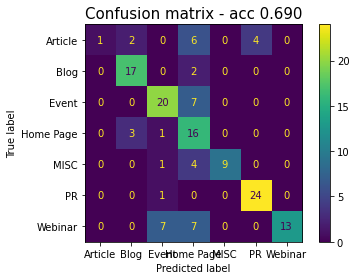


              precision    recall  f1-score   support

     Article       1.00      0.08      0.14        13
        Blog       0.77      0.89      0.83        19
       Event       0.67      0.74      0.70        27
   Home Page       0.38      0.80      0.52        20
        MISC       1.00      0.64      0.78        14
          PR       0.86      0.96      0.91        25
     Webinar       1.00      0.48      0.65        27

    accuracy                           0.69       145
   macro avg       0.81      0.66      0.65       145
weighted avg       0.80      0.69      0.68       145



In [241]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

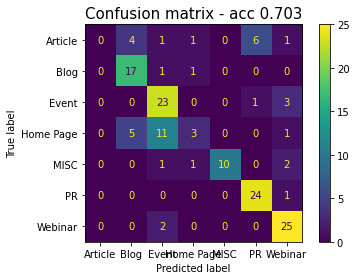


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        13
        Blog       0.65      0.89      0.76        19
       Event       0.59      0.85      0.70        27
   Home Page       0.50      0.15      0.23        20
        MISC       1.00      0.71      0.83        14
          PR       0.77      0.96      0.86        25
     Webinar       0.76      0.93      0.83        27

    accuracy                           0.70       145
   macro avg       0.61      0.64      0.60       145
weighted avg       0.64      0.70      0.64       145



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

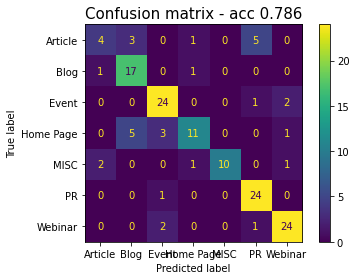


              precision    recall  f1-score   support

     Article       0.57      0.31      0.40        13
        Blog       0.68      0.89      0.77        19
       Event       0.80      0.89      0.84        27
   Home Page       0.79      0.55      0.65        20
        MISC       1.00      0.71      0.83        14
          PR       0.77      0.96      0.86        25
     Webinar       0.86      0.89      0.87        27

    accuracy                           0.79       145
   macro avg       0.78      0.74      0.75       145
weighted avg       0.79      0.79      0.77       145



In [243]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [244]:
labels_decoded

{0: 'Home Page',
 1: 'Blog',
 2: 'MISC',
 3: 'Product Page',
 4: 'Event',
 5: 'Article',
 6: 'Webinar',
 7: 'PR'}

In [245]:
print_important_features(clf, features=5)

Class "Home Page" - 5 most important features: ['clinical' 'patient' 'trial' 'post' 'iqvia']
Class "Blog" - 5 most important features: ['clinical' 'trial' 'clinical trial' 'iqvia' 'guest']
Class "MISC" - 5 most important features: ['clinical' 'patient' 'trial' 'iqvia' 'clinical trial']
Class "Event" - 5 most important features: ['content' 'post' 'trial' 'medable' 'patient']
Class "Article" - 5 most important features: ['article' 'guest' 'seo' 'conference' 'write']
Class "Webinar" - 5 most important features: ['content' 'medable' 'page' 'brand' 'post']
Class "PR" - 5 most important features: ['content' 'post' 'brand' 'page' 'write']


In [246]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
41,exuberance rational exuberance rational least ...,Article,Blog
663,GIANT Health London 6th7th December 2022 day 2...,Event,PR
447,NHS Recovery NHS recovery digital technology h...,Webinar,Event
556,IQVIA announce growth Orchestrated Customer En...,Article,PR
126,ClickMeeting good Webinar Platform 02 Stack Bl...,Home Page,Webinar
241,Foursixty Frankies Bikinis one recognizable na...,Home Page,Blog
274,Online Mortgage Lending 30 year fix Rate Loan ...,Home Page,Event
332,News event eClinical Forum happy announce publ...,MISC,Webinar
28,seo Tools Resources grow Search Traffic big in...,Home Page,Blog
694,Global Strategies accelerate Time Market Emerg...,Webinar,PR


In [247]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'lemmatized_cleaned_text']

'exuberance rational exuberance rational least human Richard Thaler lead revolution study economic understand strange way people behave money ROGER lowenstein drawing Gary Baseman possible Richard Thaler change mind economic theory go challenge become hopelessly dry touch discipline one day supposedly rational colleague house notice unable stop gorge cashew nuts would put could friend admit Thaler although mow lawn save 10 would never agree cut lawn next door return 10 even moment stick Thaler mind occur back 1970 another friend computer maven name Jeff Lasky decide skip basketball game Rochester swirling snowstorm buy ticket already would go Lasky note also Issue Giuliani New York next mayor inherit city left dead capitalism embrace resident make peace bourgeois value never really believe squeegee guy right Mound Troubles Rick Ankiel promising young left handed pitcher generation life pitching spin control humanitarian Help hurt amid complexity post cold war trouble spot aid group stu

In [248]:
# misclassified_df.loc[454, 'lemmatized_cleaned_text']

In [249]:
# misclassified_df.loc[296, 'lemmatized_cleaned_text']

In [250]:
# df_text.loc[, 'text'] # MISCLASSIFIED

In [251]:
# y_true = Webinar
# y_pred = PR
# REASON: MISCLASSIFIED
# df_text.loc[463, 'text']

# 2. Word2Vec approach

In [ ]:
# Deleting heavy variables no longer useful:
try:
  del X_train_tr
  del X_test_tr
except NameError:
  pass

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
save_variable(w2v_model, 'w2v_model')

In [ ]:
w2v_model.word_vec("test").shape

(300,)

In [ ]:
print("Shape of embedding vector", w2v_model["Natural"].shape)
print("First 20 numbers in the embedding of the word Natural\n\n", w2v_model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]


In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...
542,"Veeva Research Sites Forum, North America. Cli...",4,Veeva Research Sites Forum North America Clini...,"Veeva Research Sites Forum , North America . C...",Veeva Research Sites Forum North America Clini...,"veeva research sites forum , north america . c..."
543,Rethinking the Life Sciences Training Technolo...,6,Rethinking Life Sciences Training Technology E...,rethink the Life Sciences Training Technology ...,rethink Life Sciences Training Technology Ecos...,rethinking the life sciences training technolo...
544,Advancing Meaningful Remote Digital Endpoints ...,6,Advancing Meaningful Remote Digital Endpoints ...,advance Meaningful Remote Digital Endpoints fo...,advance Meaningful Remote Digital Endpoints Ra...,advancing meaningful remote digital endpoints ...
545,How Technology is Transforming Clinical Endpoi...,6,How Technology Transforming Clinical Endpoint ...,how Technology be Transforming Clinical Endpoi...,Technology Transforming Clinical Endpoint Adju...,how technology is transforming clinical endpoi...


In [ ]:
list_of_lists = df_text['w2v_text'].str.split().tolist()

In [ ]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 477.67it/s]


In [ ]:
print("Shape of the final embeddings for the sentences", np.array(vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(vectors)[0][:20])

Shape of the final embeddings for the sentences (547, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01040277  0.04473038  0.02847395  0.11856265 -0.08779861  0.00149163
  0.04686172 -0.06999964  0.05312994  0.02903136 -0.07205876 -0.06800598
  0.01689928  0.03158497 -0.09863865  0.04592628  0.04565423  0.09702129
  0.01392149 -0.04904693]


In [ ]:
len(vectors), vectors[0].shape

(547, (300,))

In [ ]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [ ]:
from statistics import mean

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 432.88it/s]


In [ ]:
y = df_text['label']
test_size = 0.2
random_state = 0

In [ ]:
train_data, val_data, train_cats, val_cats = train_test_split(vectors, y, 
                                                              test_size=test_size,
                                                              stratify=y, 
                                                              random_state=random_state)

In [ ]:
lr = LogisticRegression(max_iter=30000, 
                        class_weight='balanced'
                        ).fit(train_data, train_cats)

In [ ]:
y_vals = val_cats

In [ ]:
y_preds = lr.predict(val_data)

In [ ]:
y_vals.value_counts()

0    26
6    19
1    17
2    16
4    15
3     9
5     8
Name: label, dtype: int64

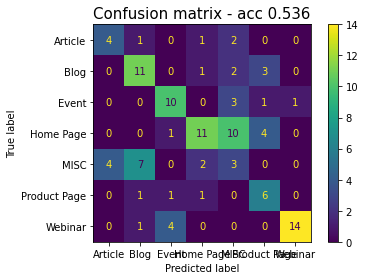

In [ ]:
# Class weight balanced
print_confusion_matrix(y_vals, y_preds, with_report=False)

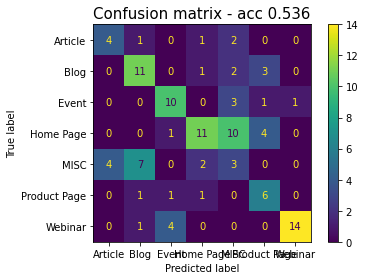

In [ ]:
print_confusion_matrix(y_vals, y_preds, with_report=False)

# 3. BERT approach (anirban sen)

In [ ]:
# Deleting heavy variables no longer useful:
try:
  del path, w2v_model
except NameError:
  pass

In [ ]:
import urllib3
urllib3.__version__

'1.25.11'

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
import torch
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid

from tqdm.notebook import tqdm, trange

# from keras.preprocessing.sequence import pad_sequences

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page,Geniuz Media The USPS undoubtedly one best cou...,Geniuz Media . the USPS be undoubtedly one of ...,Geniuz Media USPS undoubtedly one good courier...,geniuz media . the usps is undoubtedly one of ...
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC,Submit Guest Post Yes We accept guest Sponsore...,submit Guest Post . yes ! we accept guest / sp...,submit Guest Post yes accept guest sponsor pos...,submit guest post . yes ! we accept guest / sp...
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC,Digital Marketing Entrepreneurship Blog Why wo...,Digital Marketing & Entrepreneurship Blog . wh...,Digital Marketing Entrepreneurship Blog would ...,digital marketing & entrepreneurship blog . wh...
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC,Real Estate Fashion Software Travel Write us G...,"real Estate , Fashion , Software , Travel . wr...",real Estate Fashion Software Travel write guid...,"real estate , fashion , software , travel . wr..."


In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

# 3. 2nd BERT approach (Ashwin N)

## Encoding labels

In [252]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:
from datasets import load_dataset

In [254]:
! pwd

/content/drive/MyDrive/url_classification


In [255]:
df_text.head(3)

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."


In [256]:
df_text[['w2v_text', 'label']]

,w2v_text,label
0,2020 user summit . 2020 user summit * update...,4
1,write for us . want to write for us ? digita...,2
2,"write for us . yes , you . we ’re always looki...",2
3,faqs for some new features available in the be...,1
4,the best nootropic stack to replace adderall &...,5
...,...,...
717,iqvia connected intelligence ™ for integrated ...,6
718,overcoming barriers to treatment adherence wit...,6
719,""" next best "" brings intelligence to the point...",6
720,medable : virtual clinical trial solutions ( d...,0


In [257]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [258]:
df_text[TARGET].value_counts()

6    134
4    132
7    124
0    100
1     94
2     72
5     66
Name: label, dtype: int64

## Working with fixed validation data

### Preprocessing

In [259]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
717,IQVIA Connected Intelligence™ for Integrated G...,6,http://www.iqvia.com/locations/united-states/e...,IQVIA Connected Intelligence Integrated Global...,IQVIA Connected Intelligence ™ for Integrated ...,IQVIA Connected Intelligence Integrated Global...,iqvia connected intelligence ™ for integrated ...
718,Overcoming Barriers to Treatment Adherence Wit...,6,http://www.iqvia.com/locations/united-states/e...,Overcoming Barriers Treatment Adherence With F...,overcome Barriers to Treatment Adherence with ...,overcome Barriers Treatment Adherence Flexible...,overcoming barriers to treatment adherence wit...
719,"""Next Best"" Brings Intelligence to the Point o...",6,http://www.iqvia.com/locations/united-states/e...,Next Best Brings Intelligence Point Execution ...,""" Next good "" bring Intelligence to the Point ...",Next good bring Intelligence Point Execution l...,""" next best "" brings intelligence to the point..."
720,Medable: Virtual Clinical Trial Solutions (DCT...,0,http://www.medable.com/medable-events/dct-mast...,Medable Virtual Clinical Trial Solutions DCT P...,medable : Virtual Clinical Trial Solutions ( D...,medable Virtual Clinical Trial Solutions DCT P...,medable : virtual clinical trial solutions ( d...


In [260]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((504, 1), (109, 1), (109, 1), (504,), (109,), (109,))

In [261]:
y_train.value_counts()

6    94
4    92
7    86
0    70
1    66
2    50
5    46
Name: label, dtype: int64

In [262]:
y_val.value_counts()

6    20
4    20
7    19
0    15
1    14
2    11
5    10
Name: label, dtype: int64

In [263]:
y_test.value_counts()

6    20
4    20
7    19
0    15
1    14
2    11
5    10
Name: label, dtype: int64

In [264]:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_val = pd.concat([X_val, y_val], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)

# df_train.shape, df_val.shape, df_test.shape

In [265]:
# train_path, val_path, test_path = 'bert_train.csv', 'bert_val.csv', 'bert_test.csv'
# df_train.to_csv(train_path, index=False)
# df_val.to_csv(val_path, index=False)
# df_test.to_csv(test_path, index=False)

In [266]:
X_train

,text
260,Three Myths about What Customers Want. This po...
259,Why Trust Matters More Than Ever for Brands. W...
383,Network Effects: The Wireless Commitment to Su...
599,Laboratoires Théa Selects IQVIA OCE and OneKey...
366,Comparing Virtual and Traditional Sites in a P...
...,...
303,Where Business Meets Science. That’s a wrap on...
387,Accelerating Decentralized Clinical Trials Ado...
405,DCT and Digital Measures in Oncology: Meeting ...
719,"""Next Best"" Brings Intelligence to the Point o..."


In [267]:
column_used

'text'

In [268]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
         'label': y_train,
         }
         ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
         'label': y_val,
         }
         ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
         'label': y_test,
         }
         ),
    }
    )

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 504
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 109
    })
})

In [269]:
train_ds = dataset['train']

In [270]:
print(train_ds[:5])

{'text': ['Three Myths about What Customers Want. This post is the last in a three-part series.  Most marketers think that the best way to hold onto customers is through “engagement” — interacting as much as possible with them and building relationships. It turns out that that’s rarely true. In a study involving more than 7000 consumers, we found that companies often have dangerously wrong ideas about how best to engage with customers. Consider these three myths.  Myth #1: Most consumers want to have relationships with your brand.  Actually, they don’t. Only 23% of the consumers in our study said they have a relationship with a brand. In the typical consumer’s view of the world, relationships are reserved for friends, family and colleagues. That’s why, when you ask the 77% of consumers who don’t have relationships with brands to explain why, you get comments like “It’s just a brand, not a member of my family.” (What consumers really want when they interact with brands online is to get 

In [271]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
# model_ckpt = 'bert-base-uncased' # Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._8/intermediate/Gelu/mul_1' failed to allocate memory
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [272]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [273]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [274]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [275]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [276]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 2093, 17218, 2055, 2054, 6304, 2215, 1012, 2023, 2695, 2003, 1996, 2197, 1999, 1037, 2093, 1011, 2112, 2186, 1012, 2087, 3006, 2545, 2228, 2008, 1996, 2190, 2126, 2000, 2907, 3031, 6304, 2003, 2083, 1523, 8147, 1524, 1517, 21935, 2004, 2172, 2004, 2825, 2007, 2068, 1998, 2311, 6550, 1012, 2009, 4332, 2041, 2008, 2008, 1521, 1055, 6524, 2995, 1012, 1999, 1037, 2817, 5994, 2062, 2084, 6352, 2692, 10390, 1010, 2057, 2179, 2008, 3316, 2411, 2031, 20754, 3308, 4784, 2055, 2129, 2190, 2000, 8526, 2007, 6304, 1012, 5136, 2122, 2093, 17218, 1012, 10661, 1001, 1015, 1024, 2087, 10390, 2215, 2000, 2031, 6550, 2007, 2115, 4435, 1012, 2941, 1010, 2027, 2123, 1521, 1056, 1012, 2069, 2603, 1003, 1997, 1996, 10390, 1999, 2256, 2817, 2056, 2027, 2031, 1037, 3276, 2007, 1037, 4435, 1012, 1999, 1996, 5171, 7325, 1521, 1055, 3193, 1997, 1996, 2088, 1010, 6550, 2024, 9235, 2005, 2814, 1010, 2155, 1998, 8628, 1012, 2008, 1521, 1055, 2339, 1010, 2043, 2017, 3198, 1996, 6255, 1003, 1997,

In [277]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [278]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 504
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
})

In [279]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [280]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [281]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.15651318, -0.18619649,  0.05277667, ..., -0.11881161,
          0.06620602,  0.5470156 ],
        [-0.3575137 , -0.6483558 , -0.06178983, ..., -0.30401975,
          0.35076824,  0.52206844],
        [-0.27718467, -0.4459443 ,  0.18184265, ..., -0.09477948,
         -0.00757485,  0.99582815],
        [-0.28408524, -0.39167663,  0.37525547, ..., -0.21505755,
         -0.11725181,  1.0526478 ],
        [ 0.2660825 , -0.5093637 , -0.31801343, ..., -0.42029804,
          0.01444177, -0.214895  ],
        [ 0.9440614 ,  0.01117255, -0.47139454, ...,  0.14394712,
         -0.7287836 , -0.16194946]]], dtype=float32)>, hidden_states=None, attentions=None)

In [282]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [283]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [284]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 504
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 109
    })
})

In [285]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape, y_train_.shape, y_valid_.shape

((504, 768), (109, 768), (504,), (109,))

In [286]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])
X_test_.shape, y_test.shape

((109, 768), (109,))

In [287]:
X_train_

array([[ 0.0110992 , -0.10952929, -0.23900327, ..., -0.12093632,
         0.46322465,  0.34510404],
       [-0.02750245,  0.09471279, -0.10435072, ..., -0.17413628,
         0.51173776,  0.3725234 ],
       [-0.10842646, -0.28458744, -0.10063572, ..., -0.16034761,
         0.50322127,  0.04657894],
       ...,
       [-0.34089872, -0.16659556,  0.06443461, ..., -0.29136112,
         0.21907461,  0.19450934],
       [-0.21405528, -0.17711788,  0.02125168, ..., -0.31731653,
         0.36034235,  0.23671313],
       [-0.19480777, -0.19704567,  0.18957822, ..., -0.22437456,
         0.50860959,  0.36258817]])

In [288]:
X_valid_test_ = np.concatenate([X_valid_, X_test_])
X_valid_.shape, X_test_.shape, X_valid_test_.shape

((109, 768), (109, 768), (218, 768))

In [289]:
y_valid_test_ = np.concatenate([y_valid_, y_test_])
y_valid_.shape, y_test_.shape, y_valid_test_.shape

((109,), (109,), (218,))

### Modeling - machine learning approach:

In [290]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_valid_test_, y_valid_test_)

0.7935779816513762

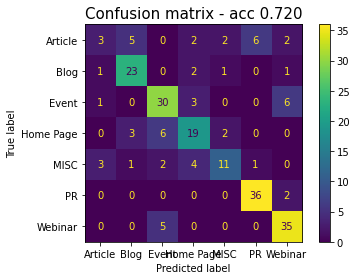


              precision    recall  f1-score   support

     Article       0.38      0.15      0.21        20
        Blog       0.72      0.82      0.77        28
       Event       0.70      0.75      0.72        40
   Home Page       0.63      0.63      0.63        30
        MISC       0.69      0.50      0.58        22
          PR       0.84      0.95      0.89        38
     Webinar       0.76      0.88      0.81        40

    accuracy                           0.72       218
   macro avg       0.67      0.67      0.66       218
weighted avg       0.70      0.72      0.70       218



In [291]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_pred = predict(rf_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

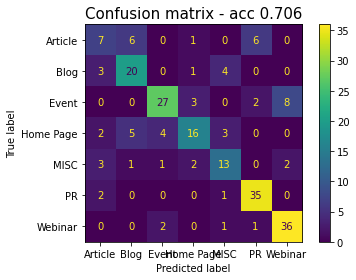


              precision    recall  f1-score   support

     Article       0.41      0.35      0.38        20
        Blog       0.62      0.71      0.67        28
       Event       0.79      0.68      0.73        40
   Home Page       0.70      0.53      0.60        30
        MISC       0.59      0.59      0.59        22
          PR       0.80      0.92      0.85        38
     Webinar       0.78      0.90      0.84        40

    accuracy                           0.71       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218



In [292]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_pred = predict(svc_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

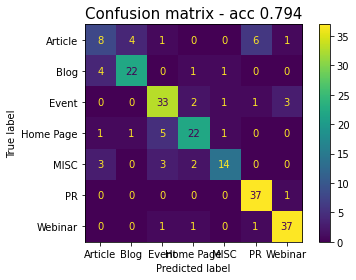


              precision    recall  f1-score   support

     Article       0.50      0.40      0.44        20
        Blog       0.81      0.79      0.80        28
       Event       0.77      0.82      0.80        40
   Home Page       0.79      0.73      0.76        30
        MISC       0.82      0.64      0.72        22
          PR       0.82      0.97      0.89        38
     Webinar       0.88      0.93      0.90        40

    accuracy                           0.79       218
   macro avg       0.77      0.75      0.76       218
weighted avg       0.79      0.79      0.79       218



In [293]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

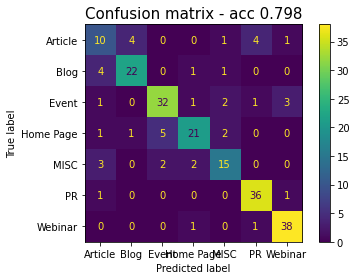


              precision    recall  f1-score   support

     Article       0.50      0.50      0.50        20
        Blog       0.81      0.79      0.80        28
       Event       0.82      0.80      0.81        40
   Home Page       0.81      0.70      0.75        30
        MISC       0.71      0.68      0.70        22
          PR       0.86      0.95      0.90        38
     Webinar       0.88      0.95      0.92        40

    accuracy                           0.80       218
   macro avg       0.77      0.77      0.77       218
weighted avg       0.80      0.80      0.80       218



In [294]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)
y_probs = lr_clf.predict_proba(X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

In [295]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
717,IQVIA Connected Intelligence™ for Integrated G...,6,http://www.iqvia.com/locations/united-states/e...,IQVIA Connected Intelligence Integrated Global...,IQVIA Connected Intelligence ™ for Integrated ...,IQVIA Connected Intelligence Integrated Global...,iqvia connected intelligence ™ for integrated ...
718,Overcoming Barriers to Treatment Adherence Wit...,6,http://www.iqvia.com/locations/united-states/e...,Overcoming Barriers Treatment Adherence With F...,overcome Barriers to Treatment Adherence with ...,overcome Barriers Treatment Adherence Flexible...,overcoming barriers to treatment adherence wit...
719,"""Next Best"" Brings Intelligence to the Point o...",6,http://www.iqvia.com/locations/united-states/e...,Next Best Brings Intelligence Point Execution ...,""" Next good "" bring Intelligence to the Point ...",Next good bring Intelligence Point Execution l...,""" next best "" brings intelligence to the point..."
720,Medable: Virtual Clinical Trial Solutions (DCT...,0,http://www.medable.com/medable-events/dct-mast...,Medable Virtual Clinical Trial Solutions DCT P...,medable : Virtual Clinical Trial Solutions ( D...,medable Virtual Clinical Trial Solutions DCT P...,medable : virtual clinical trial solutions ( d...


In [325]:
# df_text.join(X_valid_test, on=['text'])

In [ ]:
# df_text.join(X_valid_test.set_index('text'))

In [ ]:
# X_valid_test['url'] = 
# df_text.loc[[X_valid_test['text'], 'url']]

In [298]:
X_valid_test = np.concatenate([X_val, X_test]) # concatenate
X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,text,y_true,y_pred
2,Exclusive: Radiohead Sell 1.2million Copies Of...,Article,MISC
8,Interactive Advertising Bureau. Dr. Fauci was ...,Event,PR
15,Disease-related risk management is now a thing...,Article,Blog
22,Transform people practices with the cloud. The...,Blog,Article
25,POST-EVENT 2022 - CIO Tomorrow 2022. CIO TOMOR...,Home Page,Event
28,"What is Ecommerce? Definitions, Examples, And ...",MISC,Article
30,Clinical Operations in Oncology Trials West Co...,Event,Webinar
35,"Metals, Mining, Recycled Product. 1986 Royce C...",Home Page,Event
39,Veeva MedTech Quality Community Meeting. Thurs...,Event,Webinar
44,How to Use An eCommerce Quiz to Boost Customer...,Article,Blog


In [299]:
df_text.loc[104, 'text']

'Brit on the Move ™. Guest Posts With Brit on the Move™  If you are interested in writing a guest post to be featured on Brit on the Move™ you have found the right place! My passion is travel, and if you are here, you likely share the same love. I would love you to share your travel stories, favorite travel hacks, or guides here.  Let’s make sure that your stories get the attention they deserve from posting on Brit on the Move ™. This is a site with a diverse audience that always appreciates new and unusual content.  Submitting a guest post as an article will give you a platform to engage with Brit on the Move™ readers, and it will provide you with traffic and a quality do-follow back-link to your site.  Before we start, let’s cover some basics!  What is a guest post?  A guest post or guest posting is when you write content for another company’s website. Writers do this to gain traffic back to their website. In turn, this boosts their domain authority using external links to high-autho

In [300]:
df_text.loc[misclassified_df.index, ['url', 'text']]

,url,text
2,Not provided,"Write for Us. Yes, you. We’re always looking f..."
8,Not provided,Write for Us. Who Can Submit Guest Post? You ...
15,Not provided,Download: Optimize Templates for Keyword Gloss...
22,Not provided,Moz Academy. SEO Essentials Certification Lea...
25,Not provided,"Marketing automation platform for B2B, B2C, Em..."
28,Not provided,SEO Tools & Resources To Grow Your Search Traf...
30,Not provided,Keyword Research: The Beginner’s Guide by Ahre...
35,Not provided,Top 7 Account-Based Marketing Books: Get Your ...
39,Not provided,"Search listening tool for market, customer & c..."
44,Not provided,Brand monitoring tool to analyze all brand men...


In [301]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

In [302]:
misclassified_idxs = misclassified_df.index

In [303]:
total_idxs = np.arange(0, y_probs.shape[0])

In [304]:
correct_idxs = total_idxs[~np.isin(total_idxs, misclassified_idxs)]

In [305]:
assert len(correct_idxs) + len(misclassified_idxs) == len(total_idxs)
len(correct_idxs), len(misclassified_idxs), len(total_idxs)

(174, 44, 218)

In [306]:
y_probs.shape[0]

218

In [307]:
wrong_max_probs = list()
for idx in misclassified_idxs:
  prob_max = np.max(y_probs[idx])
  wrong_max_probs.append(prob_max)

correct_max_probs = list()
for idx in correct_idxs:
  prob_max = np.max(y_probs[idx])
  correct_max_probs.append(prob_max)

print(f'Average confidence of misclassified samples: {np.mean(wrong_max_probs):.4f}')
print(f'Average confidence of correctly classified samples: {np.mean(correct_max_probs):.4f}')

Average confidence of misclassified samples: 0.5977
Average confidence of correctly classified samples: 0.7657


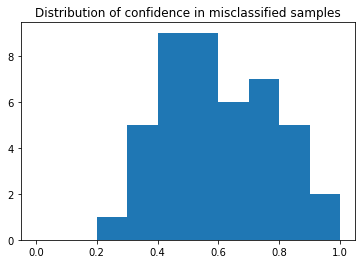

In [323]:
density=None
plt.hist(wrong_max_probs, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in misclassified samples')
plt.show()

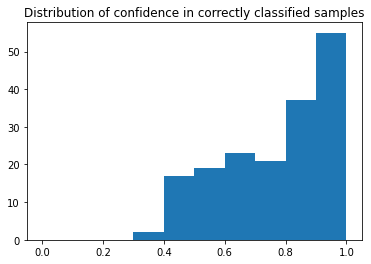

In [324]:
plt.hist(correct_max_probs, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in correctly classified samples')
plt.show()

In [314]:
y_probs[7]

array([5.30695421e-03, 1.79895571e-04, 1.35779238e-03, 1.40931432e-03,
       1.07360710e-03, 9.90465969e-01, 2.06467456e-04])

In [315]:
lr_clf.predict_proba(X_valid_test_)[0]

array([3.61914882e-02, 8.24824932e-01, 6.11455773e-02, 2.88852026e-03,
       7.33923435e-02, 9.98976477e-04, 5.58162109e-04])

In [316]:
y_valid_test_

array([1, 1, 5, 1, 6, 4, 0, 6, 4, 6, 6, 7, 0, 7, 6, 5, 6, 7, 1, 2, 6, 4,
       1, 4, 6, 0, 4, 0, 2, 0, 4, 6, 0, 7, 4, 0, 4, 4, 4, 4, 7, 4, 4, 1,
       5, 0, 2, 7, 0, 6, 2, 5, 7, 7, 2, 5, 0, 7, 1, 6, 7, 6, 0, 2, 6, 5,
       6, 6, 1, 1, 7, 7, 6, 7, 6, 4, 0, 5, 7, 6, 2, 2, 0, 7, 5, 0, 4, 1,
       7, 4, 4, 2, 7, 1, 7, 4, 2, 6, 6, 1, 0, 5, 2, 1, 1, 4, 5, 7, 4, 2,
       5, 0, 6, 5, 0, 1, 2, 6, 4, 4, 7, 6, 4, 2, 6, 2, 6, 0, 1, 2, 1, 7,
       4, 2, 5, 0, 0, 4, 6, 4, 0, 5, 6, 0, 4, 6, 0, 4, 0, 2, 4, 1, 2, 1,
       4, 5, 7, 6, 1, 4, 7, 6, 2, 2, 4, 0, 1, 6, 4, 4, 7, 7, 4, 7, 1, 0,
       7, 7, 0, 1, 7, 1, 5, 4, 0, 5, 6, 4, 1, 4, 7, 4, 7, 1, 6, 7, 0, 6,
       7, 5, 6, 7, 2, 6, 6, 5, 5, 1, 7, 7, 0, 7, 7, 4, 6, 1, 6, 6])

In [317]:
lr_clf.score(X_valid_test_, y_valid_test_)

0.7981651376146789

In [318]:
X_valid_test = np.concatenate([X_val, X_test]) # concatenate
X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

### Modeling - deep learning approach v1:

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )
tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=False, # should I shuffle or not?
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [ ]:
num_labels = len(y_train.value_counts())

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.5
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [ ]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_483', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/100
31/31 [==============================] - 37s 947ms/step - loss: 2.0492 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.0261 - val_sparse_categorical_accuracy: 0.2885
Epoch 2/100
31/31 [==============================] - 28s 915ms/step - loss: 1.9954 - sparse_categorical_accuracy: 0.3043 - val_loss: 1.9773 - val_sparse_categorical_accuracy: 0.3269
Epoch 3/100
31/31 [==============================] - 28s 916ms/step - loss: 1.9315 - sparse_categorical_accuracy: 0.4244 - val_loss: 1.9149 - val_sparse_categorical_accuracy: 0.4615
Epoch 4/100
31/31 [==============================] - 28s 914ms/step - loss: 1.8408 - sparse_categorical_accuracy: 0.4451 - val_loss: 1.8440 - val_sparse_categorical_accuracy: 0.4038
Epoch 5/100
31/31 [==============================] - 29s 922ms/step - loss: 1.7505 - sparse_categorical_accuracy: 0.4720 - val_loss: 1.7639 - val_sparse_categorical_accuracy: 0.4615
Epoch 6/100
31/31 [==============================] - 29s 921ms/step - loss: 1.6558 - spars

In [ ]:
# tf_model.fit(tf_train_dataset, 
#              validation_data=tf_eval_dataset, 
#              epochs=epochs,
#              callbacks=[callback]
#              )

In [ ]:
tf.keras.models.save_model(
    tf_model, 
    filepath='/content/drive/MyDrive/Brew/my_model_delete', 
    overwrite=True, 
    save_format='tf'
    )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [ ]:
tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf_model

In [ ]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 
# # why doesn't it work when running the next cell with the loaded model?

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [ ]:
loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

ValueError: ignored

In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

7/7 [==============================] - 2s 270ms/step - loss: 0.8470 - sparse_categorical_accuracy: 0.7692
Loss: 0.8469855189323425	 Eval Accuracy: 0.7692307829856873


In [ ]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

7/7 [==============================] - 2s 268ms/step - loss: 0.9794 - sparse_categorical_accuracy: 0.6635
Loss: 0.97944575548172	 Test Accuracy: 0.6634615659713745


In [ ]:
output_logits = tf_model.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

7/7 [==============================] - 3s 266ms/step


In [ ]:
pred_labels

array([7, 2, 0, 7, 7, 3, 0, 1, 4, 7, 7, 7, 5, 1, 6, 7, 0, 7, 7, 1, 7, 7,
       6, 0, 6, 0, 6, 5, 0, 4, 7, 7, 4, 2, 7, 0, 3, 6, 7, 4, 4, 1, 5, 7,
       5, 0, 0, 7, 3, 1, 5, 0, 1, 6, 0, 6, 6, 0, 0, 1, 1, 3, 1, 0, 7, 4,
       7, 3, 1, 2, 3, 3, 2, 2, 1, 4, 5, 0, 7, 6, 1, 0, 0, 4, 1, 2, 7, 1,
       0, 4, 1, 5, 5, 6, 1, 3, 2, 6, 0, 1, 7, 4, 7, 0])

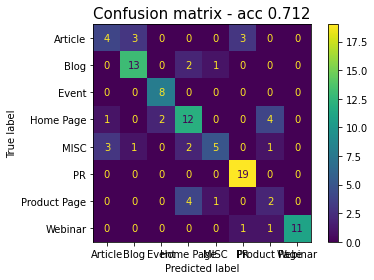


              precision    recall  f1-score   support

     Article       0.50      0.40      0.44        10
        Blog       0.76      0.81      0.79        16
       Event       0.80      1.00      0.89         8
   Home Page       0.60      0.63      0.62        19
        MISC       0.71      0.42      0.53        12
          PR       0.83      1.00      0.90        19
Product Page       0.25      0.29      0.27         7
     Webinar       1.00      0.85      0.92        13

    accuracy                           0.71       104
   macro avg       0.68      0.67      0.67       104
weighted avg       0.71      0.71      0.70       104



In [ ]:
print_confusion_matrix(y_test, pred_labels, with_report=True)

In [ ]:
pred_labels

array([7, 3, 1, 7, 7, 3, 0, 1, 4, 7, 7, 7, 7, 1, 6, 7, 0, 7, 7, 1, 7, 7,
       6, 0, 6, 0, 6, 0, 0, 4, 7, 7, 0, 2, 5, 0, 3, 6, 7, 4, 4, 1, 5, 7,
       5, 0, 1, 7, 3, 1, 5, 0, 1, 6, 0, 6, 6, 0, 0, 5, 1, 0, 1, 0, 7, 4,
       7, 0, 1, 2, 3, 0, 1, 2, 1, 4, 5, 0, 7, 6, 1, 0, 0, 4, 1, 2, 7, 1,
       0, 0, 1, 5, 5, 6, 1, 3, 2, 6, 0, 1, 7, 4, 7, 0])

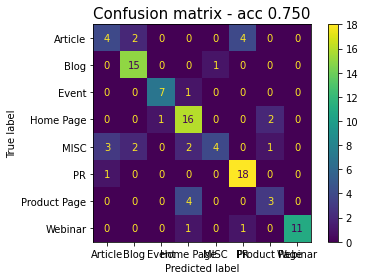


              precision    recall  f1-score   support

     Article       0.50      0.40      0.44        10
        Blog       0.79      0.94      0.86        16
       Event       0.88      0.88      0.88         8
   Home Page       0.67      0.84      0.74        19
        MISC       0.80      0.33      0.47        12
          PR       0.78      0.95      0.86        19
Product Page       0.50      0.43      0.46         7
     Webinar       1.00      0.85      0.92        13

    accuracy                           0.75       104
   macro avg       0.74      0.70      0.70       104
weighted avg       0.75      0.75      0.73       104



In [ ]:
print_confusion_matrix(y_test, pred_labels, with_report=True)

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

### Modeling - deep learning approach v2

In [ ]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((483, 1), (104, 1), (104, 1), (483,), (104,), (104,))

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train': Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'validation': Dataset.from_dict({'text': X_val[column_used],'label': y_val}),
    'test': Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
})

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained('distilgpt2')

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer2.pad_token = tokenizer2.eos_token

In [ ]:
tokenizer2

PreTrainedTokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [ ]:
tokenizer2.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [ ]:
transformers.__version__

'4.25.1'

In [ ]:
datasets.__version__

'2.7.1'

In [ ]:
# ds = datasets.Dataset.from_pandas(df_text)

In [ ]:
# ds

Dataset({
    features: ['text', 'label', 'url', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
    num_rows: 691
})

In [ ]:
# ds[0]

{'text': "2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together.",
 'label': 4,
 'url': 'Not provided',
 'cleaned_text': '2020 User Summit 2020 User Summi

In [ ]:
ds_encoded2 = ds.map(lambda row: tokenizer2(row['w2v_text'], 
                                          padding='max_length', 
                                          truncation=True,
                                          max_length=512 # is this ok? i just put a number
                                          ), 
                    batched=True,
                    remove_columns=['url', 'text', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
                    )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
ds_encoded2

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 691
})

In [ ]:
ds_encoded2[0]

{'label': 4,
 'input_ids': [42334,
  2836,
  14237,
  764,
  12131,
  2836,
  14237,
  220,
  220,
  1635,
  4296,
  532,
  9960,
  1105,
  400,
  837,
  12131,
  1635,
  220,
  220,
  351,
  262,
  7044,
  5197,
  286,
  262,
  32095,
  286,
  262,
  3298,
  17645,
  286,
  262,
  39849,
  312,
  12,
  1129,
  9471,
  290,
  262,
  2785,
  3048,
  837,
  356,
  765,
  345,
  284,
  760,
  326,
  674,
  8475,
  318,
  284,
  1394,
  674,
  14237,
  21736,
  3338,
  290,
  7981,
  764,
  220,
  220,
  981,
  674,
  936,
  2836,
  14237,
  318,
  655,
  517,
  621,
  257,
  1227,
  1497,
  837,
  356,
  389,
  8564,
  284,
  674,
  7534,
  705,
  3067,
  290,
  3747,
  764,
  503,
  286,
  281,
  20038,
  286,
  13041,
  290,
  2328,
  837,
  356,
  423,
  3066,
  284,
  14241,
  262,
  12131,
  2836,
  14237,
  287,
  262,
  1266,
  1393,
  286,
  477,
  2950,
  764,
  220,
  220,
  981,
  356,
  2911,
  326,
  356,
  477,
  460,
  290,
  481,
  8277,
  287,
  3487,
  4568,
  355,
  881

In [ ]:
ds_encoded2 = ds_encoded2.with_format('tf')

In [ ]:
ds_encoded2[0]

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'input_ids': <tf.Tensor: shape=(512,), dtype=int64, numpy=
 array([42334,  2836, 14237,   764, 12131,  2836, 14237,   220,   220,
         1635,  4296,   532,  9960,  1105,   400,   837, 12131,  1635,
          220,   220,   351,   262,  7044,  5197,   286,   262, 32095,
          286,   262,  3298, 17645,   286,   262, 39849,   312,    12,
         1129,  9471,   290,   262,  2785,  3048,   837,   356,   765,
          345,   284,   760,   326,   674,  8475,   318,   284,  1394,
          674, 14237, 21736,  3338,   290,  7981,   764,   220,   220,
          981,   674,   936,  2836, 14237,   318,   655,   517,   621,
          257,  1227,  1497,   837,   356,   389,  8564,   284,   674,
         7534,   705,  3067,   290,  3747,   764,   503,   286,   281,
        20038,   286, 13041,   290,  2328,   837,   356,   423,  3066,
          284, 14241,   262, 12131,  2836, 14237,   287,   262,  1266,
         1393,   286,   477,  295

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'])

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'], skip_special_tokens=True)

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
tf_ds = ds_encoded2.to_tf_dataset(
    batch_size=4,
    shuffle=True
)

In [ ]:
X = next(iter(tf_ds))

In [ ]:
X

{'label': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 7, 0, 0])>,
 'input_ids': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[11299,  7625,   416, ..., 50256, 50256, 50256],
        [   88, 35505,  4078, ...,   331, 35505,   220],
        [45609,   384,    78, ..., 50256, 50256, 50256],
        [ 1069, 11766,  4875, ..., 50256, 50256, 50256]])>,
 'attention_mask': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>}

In [ ]:
# Total number of minibatches in the dataset
len(tf_ds)

173

In [ ]:
num_labels

NameError: ignored

In [ ]:
from transformers import TFAutoModelForSequenceClassification
model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

## Working with validation split

In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

In [ ]:
train_ds = dataset['train']

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded

tf_model = TFAutoModel.from_pretrained(model_ckpt)

dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])

X_train_.shape, y_train_.shape

In [ ]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_test_, y_test_)

In [ ]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_test_pred = predict(rf_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_test_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_test_pred = predict(lr_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
dataset_encoded

In [ ]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )

tf_train_dataset

In [ ]:
tokenizer_columns

In [ ]:
dataset_encoded["train"]['input_ids', 'attention_mask']

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

In [ ]:
tf_model_vs = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
tf_train_array = np.array(tf_train_dataset)

In [ ]:
tf_train_dataset

In [ ]:
tf_train_array

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 3
validation_split = 0.15

tf_model_vs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy()
)

callback = EarlyStopping(monitor='val_loss',
                          patience=patience,
                          restore_best_weights=True)

tf_model_vs.fit(tf_train_array, 
             validation_split=validation_split, 
             epochs=epochs,
             callbacks=[callback]
             )